### PCAP Parsing Basics ###

This notebook is intended to roughly get a feel for what is in a PCAP (network traffic capture) file to better understand packets, sessions, the various layers, the storage mechanisms and hopefully be better informed for labeling a dataset of PCAPs.

In [1]:
# Library for dissecting PCAP files
from scapy.all import *

# Used to pull down an example PCAP file from the internet
import requests

# Converts a PDF into an image file
from pdf2image import convert_from_path

# Displays an image from file in a notebook
from IPython.display import Image

In [6]:
# Download an example PCAP file to dissect
response = requests.get('https://s3.amazonaws.com/tcpreplay-pcap-files/smallFlows.pcap', stream=True)

# Throw an error for bad status codes
response.raise_for_status()

# Save it to a file
with open('smallFlows.pcap', 'wb') as handle:
    for block in response.iter_content(1024):
        handle.write(block)

`rdpcap()` is a method from scapy that reads an existing PCAP file, dissects it and loads it into memory for analysis. It will return a list of packets in the network traffic capture. Each packet is stored in a special structure in scapy. A packet is a single unit of one-way communication from one machine to another.

In [7]:
# Read the PCAP file we downloaded, and stored it as a list of packets into the variable 'packets'
packets = rdpcap('smallFlows.pcap')

In [8]:
# This will output a summary of all packets in the capture
#packets.summary()

Since `packets` is a list, we can grab the first packet at index `0`. `pdfdump()` is a method from scapy that takes a network packet and creates a visual PDF file of that network packet.

In [10]:
# The output can be safely ignored
packets[0].pdfdump('packet1.pdf')

# Take the PDF and convert it to an image so we can view in the notebook
pages = convert_from_path('packet1.pdf', 500)
for page in pages:
    page.save('packet1.jpg', 'JPEG')

Ignoring line 15597 in mapping file 'pdftex.map': Unknown token '<MinLibBol'
Ignoring line 15598 in mapping file 'pdftex.map': Unknown token '<MinLibBol'
Ignoring line 15599 in mapping file 'pdftex.map': Unknown token '<MinLibBol'
Ignoring line 15600 in mapping file 'pdftex.map': Unknown token '<MinLibBolIta'
Ignoring line 15601 in mapping file 'pdftex.map': Unknown token '<MinLibBolIta'
Ignoring line 15602 in mapping file 'pdftex.map': Unknown token '<MinLibBolIta'
Ignoring line 15603 in mapping file 'pdftex.map': Unknown token '<MinLibIta'
Ignoring line 15604 in mapping file 'pdftex.map': Unknown token '<MinLibIta'
Ignoring line 15605 in mapping file 'pdftex.map': Unknown token '<MinLibIta'
Ignoring line 15606 in mapping file 'pdftex.map': Unknown token '<MinLibReg'
Ignoring line 15607 in mapping file 'pdftex.map': Unknown token '<MinLibReg'
Ignoring line 15608 in mapping file 'pdftex.map': Unknown token '<MinLibReg'


Before we look at the image we created from the first packet, let's look at what that packet actually looks like in it's raw form. `hexdump()` is a method from scapy that will print out 3 columns of a stored packet. The first column is the byte offset in hex, the second column (actually 16 space delimited columns) is the actual stored hex of the packet, and the final column is the ASCII repensentation of the stored hex. Some of the ascii might actually be readable as you'll see below, other parts might not have an ascii translation or might be encrypted and unreadable.

In [11]:
# Print out the raw representation of the first packet
print(hexdump(packets[0]))

0000  00 1A 8C 15 F9 80 40 61 86 9A F1 F5 08 00 45 00  ......@a......E.
0010  03 D7 76 E0 40 00 80 06 9E 7C C0 A8 03 83 48 0E  ..v.@....|....H.
0020  D5 8A DE B3 00 50 97 8A 22 98 90 B8 A4 DF 50 18  .....P..".....P.
0030  3F A0 5D F8 00 00 47 45 54 20 2F 63 6F 6D 70 6C  ?.]...GET /compl
0040  65 74 65 2F 73 65 61 72 63 68 3F 63 6C 69 65 6E  ete/search?clien
0050  74 3D 63 68 72 6F 6D 65 26 68 6C 3D 65 6E 2D 55  t=chrome&hl=en-U
0060  53 26 71 3D 63 72 20 48 54 54 50 2F 31 2E 31 0D  S&q=cr HTTP/1.1.
0070  0A 48 6F 73 74 3A 20 63 6C 69 65 6E 74 73 31 2E  .Host: clients1.
0080  67 6F 6F 67 6C 65 2E 63 61 0D 0A 43 6F 6E 6E 65  google.ca..Conne
0090  63 74 69 6F 6E 3A 20 6B 65 65 70 2D 61 6C 69 76  ction: keep-aliv
00a0  65 0D 0A 55 73 65 72 2D 41 67 65 6E 74 3A 20 4D  e..User-Agent: M
00b0  6F 7A 69 6C 6C 61 2F 35 2E 30 20 28 57 69 6E 64  ozilla/5.0 (Wind
00c0  6F 77 73 3B 20 55 3B 20 57 69 6E 64 6F 77 73 20  ows; U; Windows 
00d0  4E 54 20 36 2E 31 3B 20 65 6E 2D 55 53 29 20 41  NT 6.1; e

Now that we can see the raw packet, let's look at what that looks like visually from the image we made of the exact same packet. You'll notice that on the left the hex will all match up with what we say above in the middle column of the hexdump. This image shows what each of those bytes mean, how they got translated, and why some of them have ASCII representations while others may not.

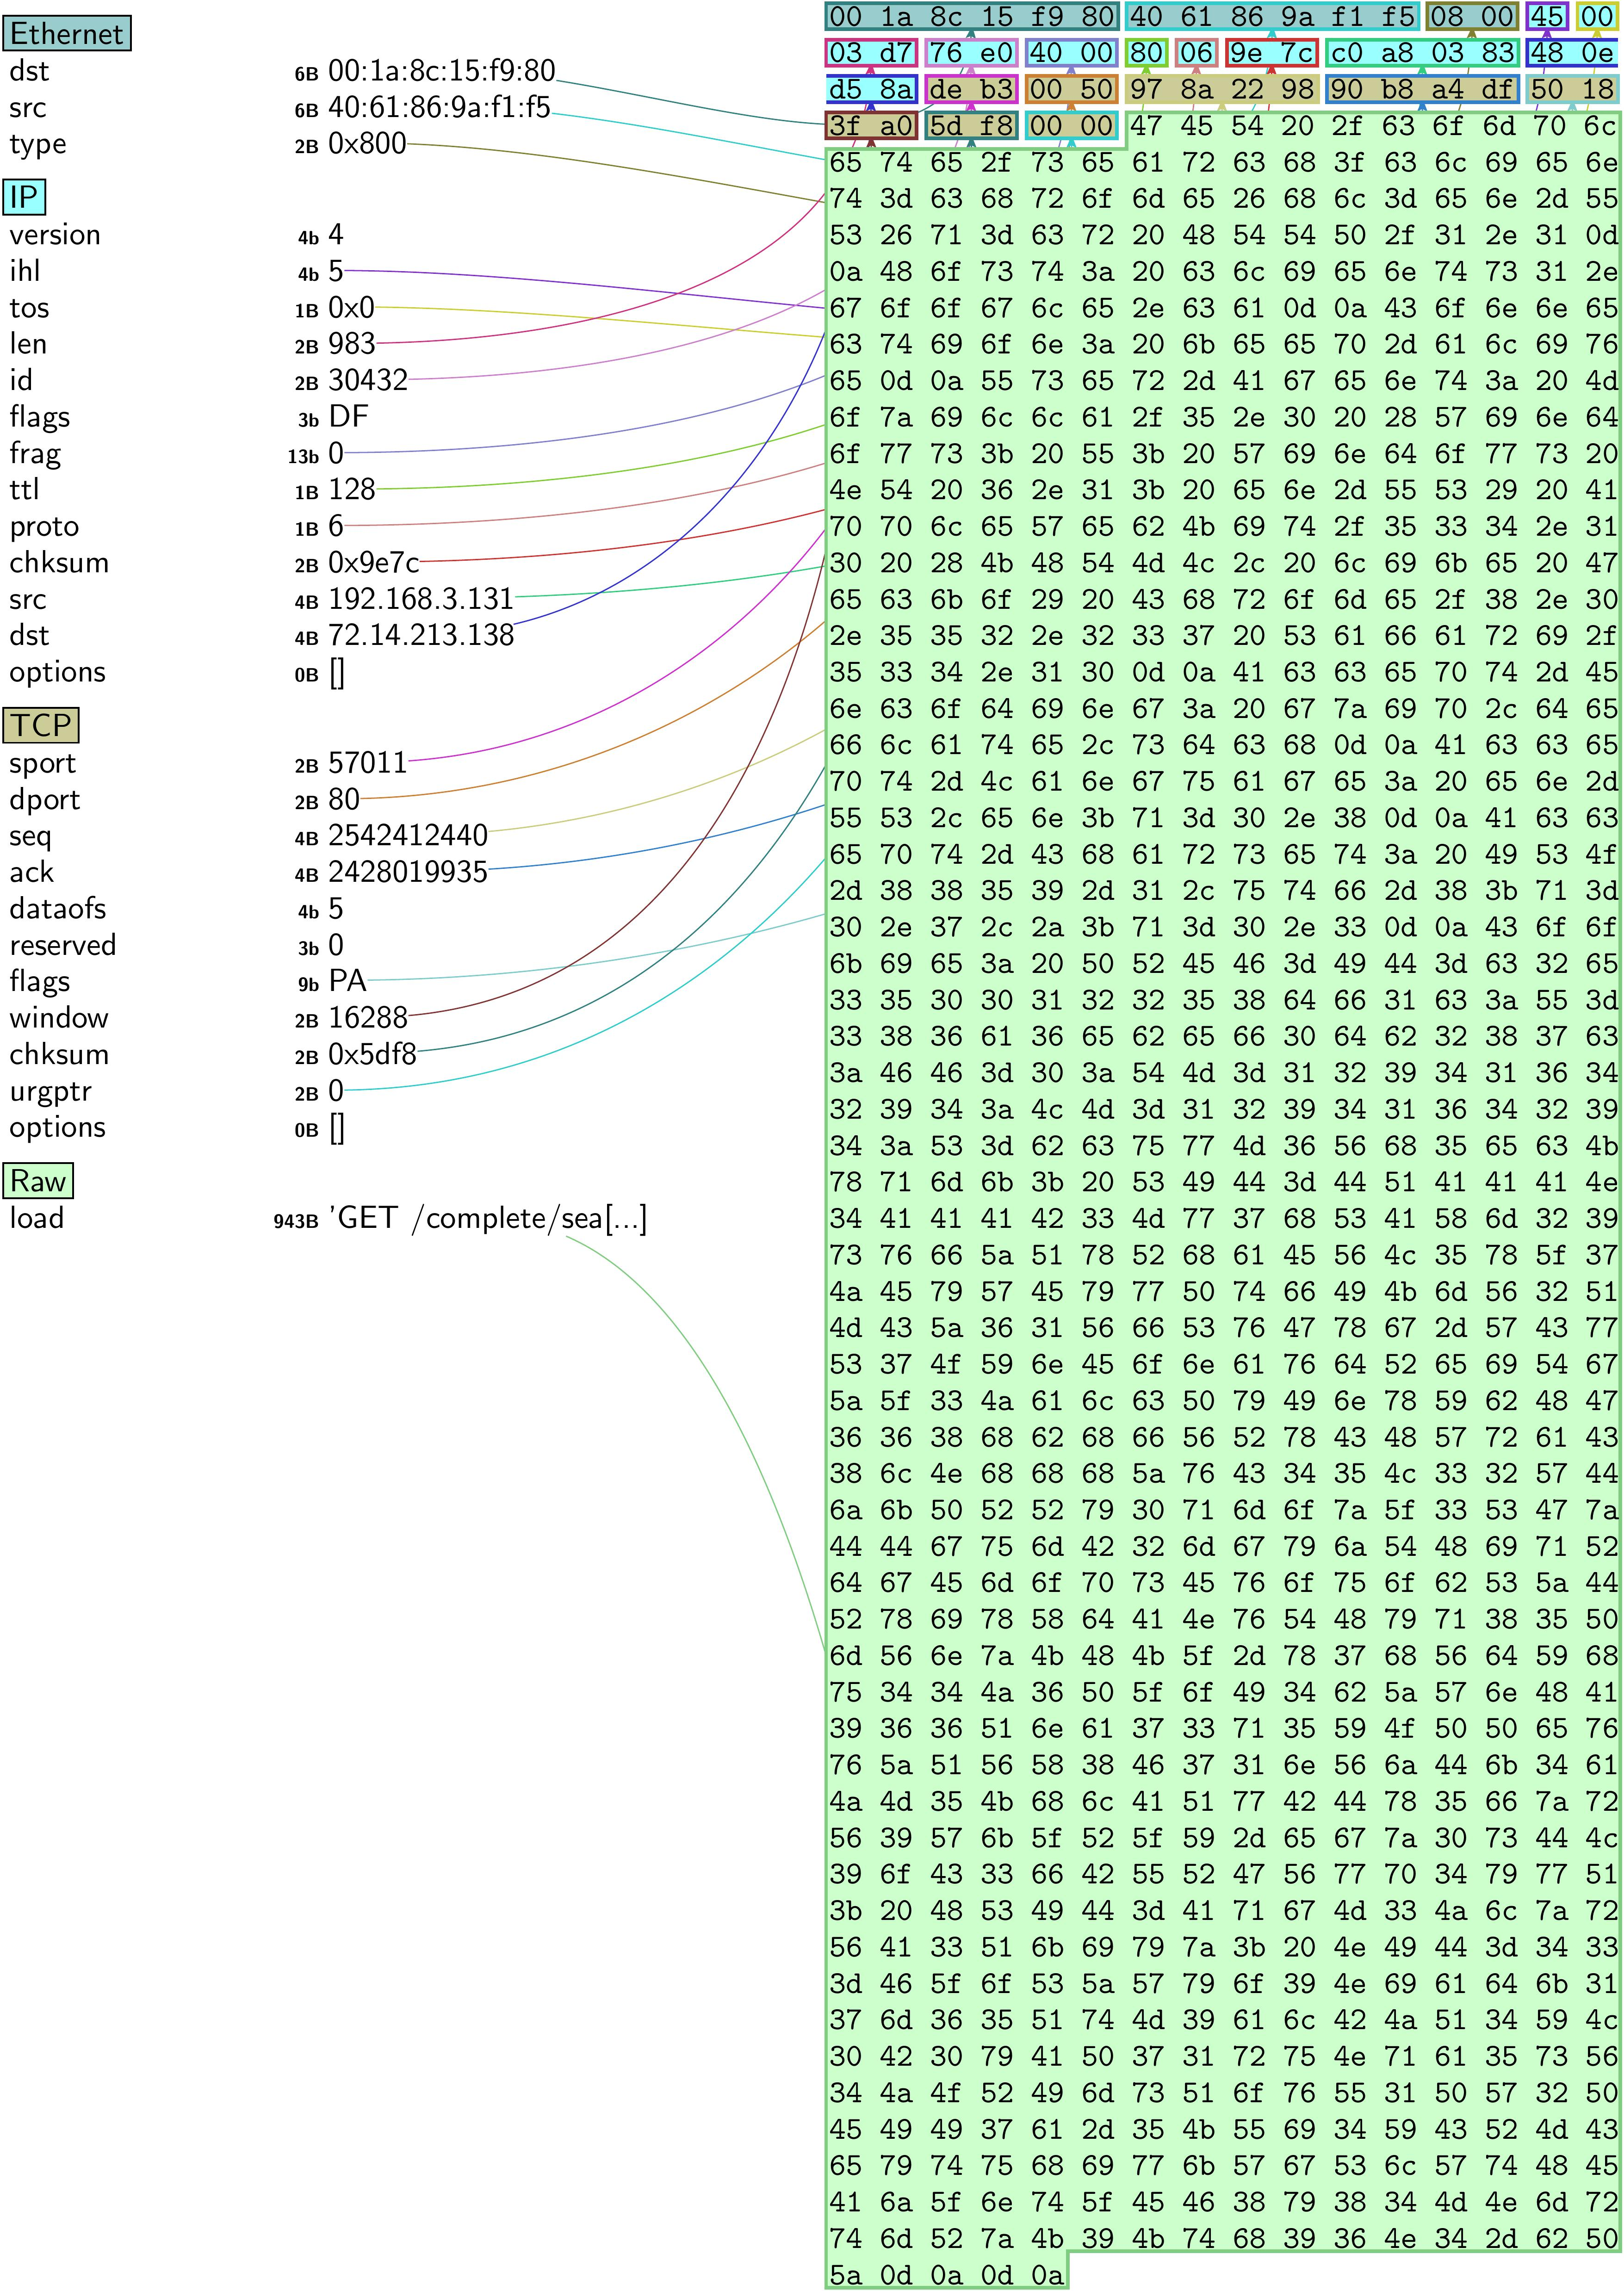

In [12]:
# Display the image we made of the first packet
Image(filename='packet1.jpg')

You'll notice above that the packet is broken up into 4 'layers' on the left: Ethernet, IP, TCP, and Raw. While each of these layers can be different based on the type of network traffic, for purposes of this, we can safely assume we'll always be dealing with Ethernet at the top, then for most cases it will be IP or IPv6, and underneath that it will be TCP, UDP, or ICMP for most cases, and finally Raw, though as you'll see later on that is the part that will intentionally be removed for most analysis.

For traffic that has the TCP or UDP layer, it is session-based traffic, meaning multiple packets make up a conversation between two machines. For example when your computer goes to google.com it establishes a TCP session with a Google server and multiple packets are sent in a two-way communication for the entire session of you browsing on google.com. Sessions can span any number of packets or time range between the two machines depending on the type and purpose of the conversation.

To get the sessions out of PCAP file using scapy, we can simply take the `packets` variable we already created and call `sessions()` on it. That will return a dictionary of sessions that contain the packets for each session.

In [15]:
# Get the sessions
sessions = packets.sessions()
# Grab a specific session
for pkts in sessions['TCP 192.168.3.131:57011 > 72.14.213.138:80']:
    # Use hexdump() to represent all of the packets in that session
    print(hexdump(pkts))

0000  00 1A 8C 15 F9 80 40 61 86 9A F1 F5 08 00 45 00  ......@a......E.
0010  03 D7 76 E0 40 00 80 06 9E 7C C0 A8 03 83 48 0E  ..v.@....|....H.
0020  D5 8A DE B3 00 50 97 8A 22 98 90 B8 A4 DF 50 18  .....P..".....P.
0030  3F A0 5D F8 00 00 47 45 54 20 2F 63 6F 6D 70 6C  ?.]...GET /compl
0040  65 74 65 2F 73 65 61 72 63 68 3F 63 6C 69 65 6E  ete/search?clien
0050  74 3D 63 68 72 6F 6D 65 26 68 6C 3D 65 6E 2D 55  t=chrome&hl=en-U
0060  53 26 71 3D 63 72 20 48 54 54 50 2F 31 2E 31 0D  S&q=cr HTTP/1.1.
0070  0A 48 6F 73 74 3A 20 63 6C 69 65 6E 74 73 31 2E  .Host: clients1.
0080  67 6F 6F 67 6C 65 2E 63 61 0D 0A 43 6F 6E 6E 65  google.ca..Conne
0090  63 74 69 6F 6E 3A 20 6B 65 65 70 2D 61 6C 69 76  ction: keep-aliv
00a0  65 0D 0A 55 73 65 72 2D 41 67 65 6E 74 3A 20 4D  e..User-Agent: M
00b0  6F 7A 69 6C 6C 61 2F 35 2E 30 20 28 57 69 6E 64  ozilla/5.0 (Wind
00c0  6F 77 73 3B 20 55 3B 20 57 69 6E 64 6F 77 73 20  ows; U; Windows 
00d0  4E 54 20 36 2E 31 3B 20 65 6E 2D 55 53 29 20 41  NT 6.1; e

In [18]:
# We can also summarize specific packets
packets[0].summary()

'Ether / IP / TCP 192.168.3.131:57011 > 72.14.213.138:80 PA / Raw'

In [19]:
# Or represent that same single packet in a more human-readable format
packets[0].show()

###[ Ethernet ]### 
  dst       = 00:1a:8c:15:f9:80
  src       = 40:61:86:9a:f1:f5
  type      = 0x800
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 983
     id        = 30432
     flags     = DF
     frag      = 0
     ttl       = 128
     proto     = 6
     chksum    = 0x9e7c
     src       = 192.168.3.131
     dst       = 72.14.213.138
     \options   \
###[ TCP ]### 
        sport     = 57011
        dport     = 80
        seq       = 2542412440
        ack       = 2428019935
        dataofs   = 5
        reserved  = 0
        flags     = PA
        window    = 16288
        chksum    = 0x5df8
        urgptr    = 0
        options   = []
###[ Raw ]### 
           load      = 'GET /complete/search?client=chrome&hl=en-US&q=cr HTTP/1.1\r\nHost: clients1.google.ca\r\nConnection: keep-alive\r\nUser-Agent: Mozilla/5.0 (Windows; U; Windows NT 6.1; en-US) AppleWebKit/534.10 (KHTML, like Gecko) Chrome/8.0.552.237 Safari/534.10\r\nAccept-Encoding:

In [33]:
# Let's use that same PCAP but now remove the payloads from all of the packets
INFILE = 'smallFlows.pcap'
OUTFILE = 'smallFlows_nopayloads.pcap'
with PcapWriter(OUTFILE) as dest:
    with PcapReader(INFILE) as infile:
        for pkt in infile:
            if TCP in pkt:
                pkt[TCP].remove_payload()
            elif UDP in pkt:
                pkt[UDP].remove_payload()
            dest.write(pkt)

Let's run through the same steps, but now against the newly created PCAP file that has all of the same packets and sessions, except all of the payloads (Raw layer, or sensitive parts of the network traffic) have been removed.

In [2]:
packets = rdpcap('smallFlows_nopayloads.pcap')

In [35]:
packets[0].pdfdump('packet1_nopayloads.pdf')

Ignoring line 15597 in mapping file 'pdftex.map': Unknown token '<MinLibBol'
Ignoring line 15598 in mapping file 'pdftex.map': Unknown token '<MinLibBol'
Ignoring line 15599 in mapping file 'pdftex.map': Unknown token '<MinLibBol'
Ignoring line 15600 in mapping file 'pdftex.map': Unknown token '<MinLibBolIta'
Ignoring line 15601 in mapping file 'pdftex.map': Unknown token '<MinLibBolIta'
Ignoring line 15602 in mapping file 'pdftex.map': Unknown token '<MinLibBolIta'
Ignoring line 15603 in mapping file 'pdftex.map': Unknown token '<MinLibIta'
Ignoring line 15604 in mapping file 'pdftex.map': Unknown token '<MinLibIta'
Ignoring line 15605 in mapping file 'pdftex.map': Unknown token '<MinLibIta'
Ignoring line 15606 in mapping file 'pdftex.map': Unknown token '<MinLibReg'
Ignoring line 15607 in mapping file 'pdftex.map': Unknown token '<MinLibReg'
Ignoring line 15608 in mapping file 'pdftex.map': Unknown token '<MinLibReg'


In [21]:
print(hexdump(packets[0]))

0000  00 1A 8C 15 F9 80 40 61 86 9A F1 F5 08 00 45 00  ......@a......E.
0010  03 D7 76 E0 40 00 80 06 9E 7C C0 A8 03 83 48 0E  ..v.@....|....H.
0020  D5 8A DE B3 00 50 97 8A 22 98 90 B8 A4 DF 50 18  .....P..".....P.
0030  3F A0 5D F8 00 00                                ?.]...
None


In [22]:
#packets.summary()

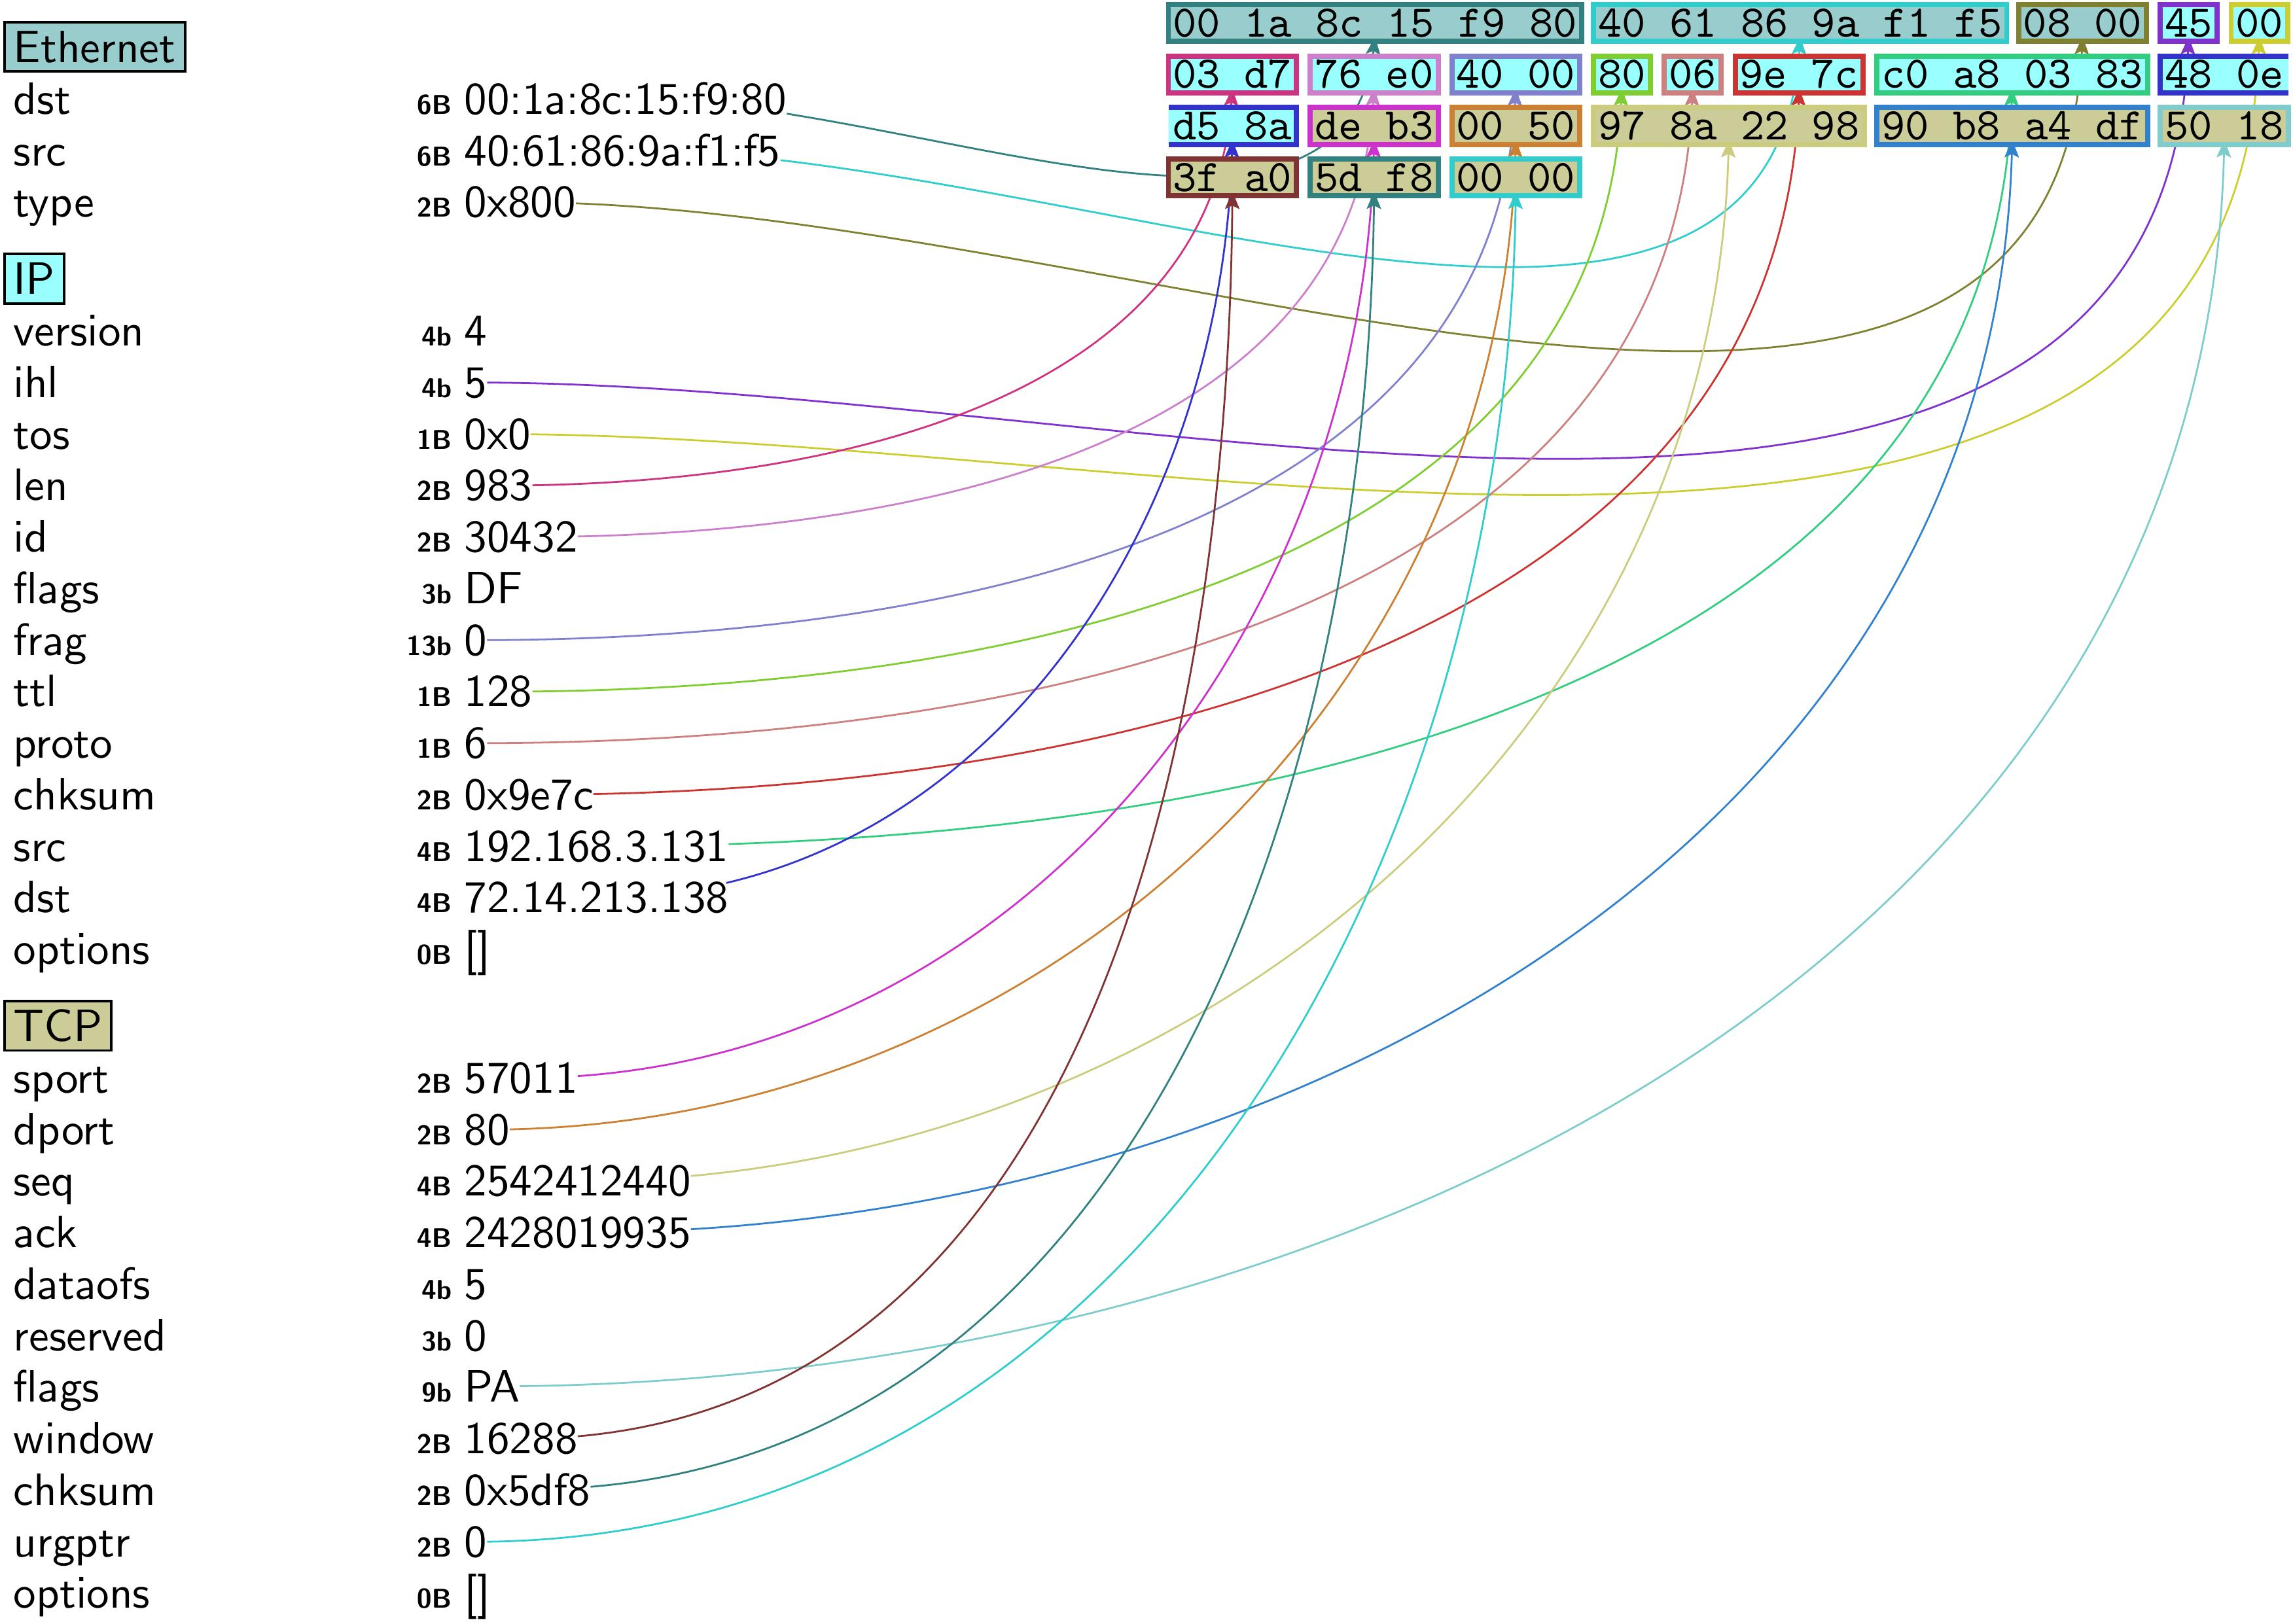

In [23]:
pages = convert_from_path('packet1_nopayloads.pdf', 500)
for page in pages:
    page.save('packet1_nopayloads.jpg', 'JPEG')
    
Image(filename='packet1_nopayloads.jpg')

In [3]:
sessions = packets.sessions()
for pkts in sessions['TCP 192.168.3.131:57011 > 72.14.213.138:80']:
    print(hexdump(pkts))

0000  00 1A 8C 15 F9 80 40 61 86 9A F1 F5 08 00 45 00  ......@a......E.
0010  03 D7 76 E0 40 00 80 06 9E 7C C0 A8 03 83 48 0E  ..v.@....|....H.
0020  D5 8A DE B3 00 50 97 8A 22 98 90 B8 A4 DF 50 18  .....P..".....P.
0030  3F A0 5D F8 00 00                                ?.]...
None
0000  00 1A 8C 15 F9 80 40 61 86 9A F1 F5 08 00 45 00  ......@a......E.
0010  00 28 76 EF 40 00 80 06 A2 1C C0 A8 03 83 48 0E  .(v.@.........H.
0020  D5 8A DE B3 00 50 97 8A 26 47 90 B8 A6 61 50 10  .....P..&G...aP.
0030  3F 40 BA E0 00 00                                ?@....
None
0000  00 1A 8C 15 F9 80 40 61 86 9A F1 F5 08 00 45 00  ......@a......E.
0010  03 D9 76 F0 40 00 80 06 9E 6A C0 A8 03 83 48 0E  ..v.@....j....H.
0020  D5 8A DE B3 00 50 97 8A 26 47 90 B8 A6 61 50 18  .....P..&G...aP.
0030  3F 40 F7 BB 00 00                                ?@....
None
0000  00 1A 8C 15 F9 80 40 61 86 9A F1 F5 08 00 45 00  ......@a......E.
0010  00 28 76 F1 40 00 80 06 A2 1A C0 A8 03 83 48 0E  .(v.@.........H.
0020  D

In [25]:
packets[0].summary()

'Ether / IP / TCP 192.168.3.131:57011 > 72.14.213.138:80 PA'

In [26]:
packets[0].show()

###[ Ethernet ]### 
  dst       = 00:1a:8c:15:f9:80
  src       = 40:61:86:9a:f1:f5
  type      = 0x800
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 983
     id        = 30432
     flags     = DF
     frag      = 0
     ttl       = 128
     proto     = 6
     chksum    = 0x9e7c
     src       = 192.168.3.131
     dst       = 72.14.213.138
     \options   \
###[ TCP ]### 
        sport     = 57011
        dport     = 80
        seq       = 2542412440
        ack       = 2428019935
        dataofs   = 5
        reserved  = 0
        flags     = PA
        window    = 16288
        chksum    = 0x5df8
        urgptr    = 0
        options   = []



In [4]:
import pandas

In [5]:
len(packets)

14261

In [6]:
len(sessions)

1211

In [7]:
for session in sessions:
    print(len(session))

42
42
42
42
43
43
42
42
40
40
42
42
43
40
42
43
40
42
40
40
44
42
44
42
40
40
41
41
42
42
42
42
42
42
40
42
40
42
42
41
42
41
43
43
43
43
43
43
43
43
42
42
46
41
41
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
41
41
43
43
43
43
43
42
42
43
43
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
42
42
41
41
41
41
41
41
41
41
41
41
41
41
42
42
42
42
41
41
42
42
44
44
43
41
43
42
42
42
44
42
41
44
40
40
40
40
40
40
44
44
40
40
40
40
42
40
40
42
40
40
40
40
40
40
40
40
40
40
40
40
41
42
40
40
43
43
40
40
40
40
40
40
40
40
40
40
40
40
43
43
43
43
43
43
43
43
40
40
43
43
43
43
43
43
40
40
40
40
40
40
40
40
43
43
43
43
43
43
42
42
41
41
41
41
42
42
41
41
41
41
42
42
42
42
44
44
40
40
40
40
40
40
43
43
43
43
42
42
40
40
43
42
43
42
41
41
41
41
42
42
44
44
44
44
43
43
42
42
40
40
40
40
43
43
43
43
40
40
43
43
42
42
43
43
43
43
42
42
42
42
42
42
40
40
40
40
41
41
35
43
43
29
29
41
41
41
41
41
41
40
40
40
40
40
40
40
40
36
36
44
40
35
41
44
4

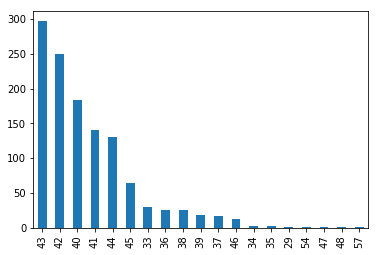

In [8]:
session_list = []
for session in sessions:
    session_list.append(len(session))
pandas.Series(session_list).value_counts().plot('bar')

In [15]:
packets[0]

<Ether  dst=00:1a:8c:15:f9:80 src=40:61:86:9a:f1:f5 type=0x800 |<IP  version=4 ihl=5 tos=0x0 len=983 id=30432 flags=DF frag=0 ttl=128 proto=6 chksum=0x9e7c src=192.168.3.131 dst=72.14.213.138 |<TCP  sport=57011 dport=80 seq=2542412440 ack=2428019935 dataofs=5 reserved=0 flags=PA window=16288 chksum=0x5df8 urgptr=0 |>>>

In [16]:
packets[0][Ether].src

'40:61:86:9a:f1:f5'

In [17]:
packets[0][Ether].dst

'00:1a:8c:15:f9:80'

In [18]:
packets[0][Ether].type

2048

In [23]:
counter1 = 0
counter2 = 0
for packet in packets:
    if Ether in packet:
        counter1 += 1
    else:
        counter2 += 1

In [24]:
print(counter1, counter2)

14261 0


In [43]:
counter1 = 0
counter2 = 0
ip_version = []
for packet in packets:
    if IP in packet[Ether]:
        counter1 += 1
        ip_version.append(packet[Ether][IP].ttl)
    elif ARP in packet[Ether]:
        counter2 += 1
    else:
        packet[Ether].show()

In [33]:
counter1

14243

In [32]:
counter2

18

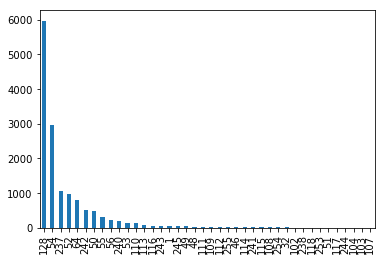

In [44]:
pandas.Series(ip_version).value_counts().plot('bar')